# <b>Anime Recommender System Using Hybrid Filter</b>
<b>Muhammed Rüşen Birben 150220755</b>

## <b>1 - Data Preparing and Understanding</b>

### <b>1.a Preparing Anime Info Dataframes</b>

#### Importing pandas and reading anime csv files

In [ ]:
# ALL RELATED LIBRARIES FOR THIS NOTEBOOK
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install scipy
# !pip install matplotlib
# !pip install seaborn
# !pip install yake
# Note: functions from os library is imported in this
# notebook, it is only used for a couple folder creation
# and variable saving

import pandas as pd
import numpy as np
from pathlib import Path

anime_synopsis = pd.read_csv("data_raw/data/anime_with_synopsis.csv")
anime_df = pd.read_csv("data_raw/data/anime.csv")

#### Getting info for both dfs

In [ ]:
anime_df.iloc[:,0:19].info()

In [ ]:
anime_df.iloc[:,19:].info()

In [ ]:
anime_synopsis.info()

#### Dropping duplicates for both

In [ ]:
before = len(anime_df.index)
anime_df.drop_duplicates(inplace=True)
after = len(anime_df.index)
print(f"Before anime {before:,}\nAfter anime {after:,}")

before = len(anime_synopsis.index)
anime_synopsis.drop_duplicates(inplace=True)
after = len(anime_synopsis.index)
print(f"Before anime_synopsis {before:,}\nAfter anime_synopsis {after:,}")
del after, before

#### Renaming columns of dfs

In [ ]:
print(anime_df.columns)
print("Feature num: ",anime_df.shape[1])
anime_df.rename(columns={"English name":"english_name", "Japanese name":"japanese_name",
 "On-Hold":"on_hold", "Plan to Watch":"plan_to_watch", "MAL_ID":"anime_id"}, inplace=True)
anime_df.rename(columns={i:i.replace("-","_") for i in anime_df.columns}, inplace=True)
anime_df.rename(columns={i:i.lower() for i in anime_df.columns}, inplace=True)
print(anime_df.columns)

In [ ]:
print(anime_synopsis.columns)
print("Feature num: ",anime_synopsis.shape[1])
anime_synopsis.rename(columns={"MAL_ID":"anime_id", "sypnopsis":"synopsis"}, inplace=True)
anime_synopsis.rename(columns={i:i.replace("-","_") for i in anime_synopsis.columns}, inplace=True)
anime_synopsis.rename(columns={i:i.lower() for i in anime_synopsis.columns}, inplace=True)
print(anime_synopsis.columns)

#### Filter Adult Content

In [ ]:
# will use adult_anime_ids for filtering the ratings of adult animes later on
adult_anime_ids = anime_df[anime_df['rating'] == 'Rx - Hentai']['anime_id'] # Rx-Hentai is basically P*rn* in anime style
print(f"There were {len(adult_anime_ids):,} adult animes. They are filtered.")
anime_df = anime_df[anime_df['rating'] != 'Rx - Hentai']
anime_synopsis = anime_synopsis[anime_synopsis.index.isin(anime_df.index)]

#### Fill 'Unknown' With np.nan or Zero for Numeric Values

In [ ]:
# NUMERIC
to_int = ["episodes", "score_10","score_9","score_8","score_7","score_6","score_5","score_4","score_3","score_2","score_1"]
to_float = ["score"]

# I have done various experiments with these features, rank seems to be the best
# and the most reliable measure among these.
for i in to_int:
    print(f"feature: {i}, {(anime_df[i] == 'Unknown').sum()} unknown values filled.")
    anime_df.loc[:,i]= anime_df[i].apply(lambda x: 0 if x == "Unknown" else x)
    anime_df.loc[:,i] = anime_df[i].astype(float) # "0.0" could not be connverted directly to 0 so first make it float, than int
    anime_df.loc[:,i] = anime_df[i].astype(int)

for i in to_float:
    print(f"feature: {i}, {(anime_df[i] == 'Unknown').sum()} unknown values filled.")
    anime_df.loc[:,i]= anime_df[i].apply(lambda x: np.nan if x == "Unknown" else x)
    anime_df.loc[:,i] = anime_df[i].astype(float)
    anime_synopsis.loc[:,i]= anime_synopsis[i].apply(lambda x: np.nan if x == "Unknown" else x)
    anime_synopsis.loc[:,i] = anime_synopsis[i].astype(float)


print(f"feature: ranking, {(anime_df['ranked'] == 'Unknown').sum()} unknown values filled.")
anime_df.loc[:,'ranked'] = anime_df['ranked'].replace('Unknown', np.nan)
anime_df.loc[:,'ranked'] = anime_df['ranked'].astype(float)
anime_df.loc[:,'ranked'] = anime_df['ranked'].fillna(anime_df['ranked'].max()+1)
anime_df.loc[:,'ranked'] = anime_df['ranked'].astype(int)



# STRING

# For the synopsis 'No synopsis information has been added to ...' should be mapped with empty string
# If we will later on use synopsis info these values should be cleansed
no_syn = 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here .'
anime_synopsis.synopsis.replace(no_syn, '', inplace=True)
anime_synopsis.synopsis.fillna('', inplace=True)
print("There are ", len(anime_synopsis.synopsis[anime_synopsis.synopsis == '']), "empty synopsis (snopsis == '') ")

del i, to_float, to_int, no_syn

#### Looking for na

In [ ]:
anime_df.isna().sum()[anime_df.isna().sum() != 0] 
# Some score are missing (won't need for content based filtering)

In [ ]:
anime_synopsis.isna().sum()[anime_synopsis.isna().sum() != 0] 
# some scores are missing (won't need for content based filtering, in fact for this df we will only use the synopsis column) 

#### Saving as csv

In [ ]:
Path("./data_cleansed/").mkdir(parents=True, exist_ok=True)

anime_df.to_csv("data_cleansed/anime_info.csv", index=False)
anime_synopsis.to_csv("data_cleansed/anime_synopsis.csv", index=False)

del anime_synopsis, anime_df

### <b>1.b Preparing Ratings Dataframe</b>

#### Reading the rating dataset & dropping the duplicates

In [ ]:
# A large dataset (takes about 1 min to load & remove duplicates)
# (might even give an error depending on RAM)
rating_master = pd.read_csv('data_raw/data/animelist.csv')
print(f"Before removing duplicate elements: {len(rating_master.index):,} ratings")
rating_master.drop_duplicates(inplace=True)
print(f"After removing duplicate elements: {len(rating_master.index):,} ratings")

#### Looking for info

In [ ]:
rating_master.info()

In [ ]:
rating_master.isna().sum()[rating_master.isna().sum() != 0] # No feature with na in it

#### Filtering Adult Anime Ratings and Biased Ratings

In [ ]:
rating_master = rating_master[~rating_master['anime_id'].isin(adult_anime_ids)]
del adult_anime_ids

In [ ]:
rating_master = rating_master[rating_master['watching_status'] != 6]
# If watching status == 6 => plan to watch then filter them out
# users gave rating without even watching a bit, biased

# we won't need these features anymore
rating_master = rating_master[['user_id', 'anime_id', 'rating']]  
print("There were 109,224,746 ratins before.")
print(f"Now with filtering there are {len(rating_master.index):,} ratings")

#### Saving rating files to cvs
Warning: takes too long to save csv

In [ ]:
# this step takes a bit long too (1 min 30 sec approx.)
rating_master.to_csv("data_cleansed/ratings.csv", index=False)
del rating_master

### <b>1.c Reading watching status mapping csv</b>

In [ ]:
temp = pd.read_csv("data_raw/data/watching_status.csv")

In [ ]:
print(temp) # nothing to clear, can keep these in mind. (i won't need though)
# not worth copying to clensed_data folder
del temp

## Cleansed Data Summary:

In [ ]:
# from os import listdir
# print("Raw data consisted of these (excluding html folder)")
# listdir('data_raw/data/')

In [ ]:
# listdir('data_cleansed')

 - <b>anime_info.csv:</b> consist of animes' detailed information like genre, studio, airing year, ratings number for each rate degree etc.<br>
 - <b>anime_synopsis.csv:</b> consist of basic info about anime like score and genre. But most importantly it includes the synopsis of anime. (Might use synopsis with term frequency algorithm. Or i might not use it, Haven't decided yet)<br>
 - <b>ratings.csv:</b> includes all of the ratings of users that are given for animes which user actually watched compleatly. (watching_status==2)<br> Watching status is a feature that exist in animelist.csv file. I only considered the subset of animelist.csv which is saved as ratings.csv
* NOTE: I did not use watching_status.csv and rating_complete.csv as i have only used animelist.csv that consist of all the ratings and filtered out ratings that are given without watching the anime (watching_status == 6)

## <b>2 -  Data Preprocessing</b>

In [ ]:
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import yake
from pathlib import Path
from scipy.sparse import csr_matrix, save_npz
import scipy.sparse
sns.set()

### 2.a Reading Cleansed Anime and Rating CSVs

In [ ]:
# These two will be our master variables throughout the preprocessing part
# We will only delete these at the end of this section
ratings = pd.read_csv('data_cleansed/ratings.csv')
animes = pd.read_csv('data_cleansed/anime_info.csv')

### 2.b Ratings: Removing Outlier Users' Ratings and Unpopular Anime's Ratings, Select Ratings and Scale

#### Removing Outliers: filter users that give very few (or very  large) number of ratings 

In [ ]:
# If a user rated too many anime we consider them as outlier. They might be bots
# Or the opposite is also true, some users are crazy enough to create fake accounts and
# boost the anime they are fan of by giving high scores (resulting in some users giving only a few ratings). We will eliminate them. 
plt.boxplot(ratings.user_id.value_counts())
plt.title('Boxplot of each users number of ratings')
plt.show()
# bad

In [ ]:
# Detecting and filtering out outlier users 
# some users have more than necessary ratings (max user has 15000 ratings. might be even
# a bot, or a real weeb :) and some have very few reviews. we don't want to include them.
temp_df = ratings.user_id.value_counts() # df that holds num of rating for each user

IQR = temp_df.quantile(q=0.75) - temp_df.quantile(q=0.25)
u_bound = (temp_df.quantile(q=0.75) + 1.5*IQR)
l_bound = (temp_df.quantile(q=0.25) - 1.5*IQR)
outlier_filter = temp_df.between(left=l_bound, right=u_bound)


print(f"Before outlier removal user num: {len(temp_df.index):,}")
print(f"Before outlier removal rating num: {len(ratings.index):,}")
print(f"Before outlier removal rated anime num:\
    {len(ratings.anime_id.value_counts().index):,}")
print("########################################################")
print("####################   Outlier Removal   ###############")
print("########################################################")
ratings = ratings[ratings['user_id'].isin((temp_df[outlier_filter]).index)] # filtering

print(f"After outlier removal user num: {len(temp_df[outlier_filter].index):,}")
print(f"After outlier removal rating num: {len(ratings.index):,}")
print(f"After outlier removal rated anime num:\
    {len(ratings.anime_id.value_counts().index):,}")

del temp_df, outlier_filter, IQR, u_bound, l_bound

In [ ]:
plt.boxplot(ratings.user_id.value_counts())
plt.title('Boxplot of each users number of ratings after outlier removal')
plt.show()
# better

But there are still users with one or really less number of ratings. They will not provide us any (or very very little) information.

#### Selecting ratings: make sure there aren't any user that give less ratings than the specified threashold

In [ ]:
plt.hist(ratings['user_id'].value_counts(),bins=50)
plt.xticks(np.arange(0,800,30), rotation=90)
plt.ylabel('Number of User')
plt.xlabel('Given Rating Num')
plt.show()
ratings['user_id'].value_counts().describe()

In [ ]:
temp_df = ratings.user_id.value_counts()
temp_rating_filter = temp_df >= 66 # Threshold: > 0.25 percentile
ratings = ratings[ratings['user_id'].isin((temp_df[temp_rating_filter]).index)]
del temp_rating_filter, temp_df

In [ ]:
plt.hist(ratings['user_id'].value_counts(),bins=50)
plt.xticks(np.arange(0,800,30), rotation=90)
plt.ylabel('Number of User')
plt.xlabel('Given Rating Num')
plt.show()
ratings['user_id'].value_counts().describe()

#### Selecting ratings again: this time for animes that are rated really few times

In [ ]:
ratings['anime_id'].value_counts().describe()

In [ ]:
print(f"Before non populer anime removal user num: {len(ratings.user_id.value_counts().index):,}")
print(f"Before non populer anime removal rating num: {len(ratings.index):,}")
print(f"Before non populer anime removal rated anime num: {len(ratings.anime_id.value_counts().index):,}")

temp_df = ratings['anime_id'].value_counts()
anime_filter = temp_df.quantile(0.25, interpolation='nearest')# with 11 ratings we won't get many info related to anime
temp_df = temp_df[temp_df > int(anime_filter)]
ratings = ratings[ratings['anime_id'].isin(temp_df.index)]

print("\n")
print(f"After non populer anime removal user num: {len(ratings.user_id.value_counts().index):,}")
print(f"After non populer anime removal rating num: {len(ratings.index):,}")
print(f"After non populer anime removal rated anime num: {len(temp_df.index):,}")
del temp_df, anime_filter


#### Scaling Ratings

In [ ]:
scaler = preprocessing.MinMaxScaler()
ratings['rating'] = scaler.fit_transform(np.array(ratings['rating']).reshape(-1,1))
del scaler

### 2.c Anime Info DataFrame: Selecting Animes (Filter Out Really Unpopuler or Unloved Ones)
By feature engineering & comparing with ratings

#### Feature Engineering and Filtering Based on Created Features
Trying to get two measures: How relevant anime is and how loved is it.

In [ ]:
sns.heatmap(animes.corr())
plt.show()

In [ ]:
## These two features will be used in relevancy

w = preprocessing.normalize([np.array(animes['watching'])])
p = preprocessing.normalize([np.array(animes['plan_to_watch'])])
o = preprocessing.normalize([np.array(animes['on_hold'])])
c = preprocessing.normalize([np.array(animes['completed'])])
d = preprocessing.normalize([np.array(animes['dropped'])]) # user changed mind and didn't watch: negative

animes.ranked.replace(0,animes.ranked.max()+1, inplace=True)
r_p = preprocessing.normalize([1/np.array(animes['ranked'])]) # r_p: rank point

# popularity and ranking of 2 animes are 0, which is not valid actually (and was not mentioned by the author of the data)
# so i had to fill these values up by manually, i filled them by animes.feature.max() + 1 as i believe if they
# were to be popular they wouldn't have invalid values for popularity
animes.popularity.replace(0,animes.popularity.max()+1, inplace=True)
pp = preprocessing.normalize([1 / np.array(animes['popularity'])])

m = preprocessing.normalize([np.array(animes['members'])])
f = preprocessing.normalize([np.array(animes['favorites'])])

# gave really low score: negative (h: hatred)
h = preprocessing.normalize([np.array(animes[['score_3', 'score_2', 'score_1']].sum(axis=1))]) 

# How many users rated that anime: rate count
rc = preprocessing.normalize([np.array(animes.loc[:,"score_10":"score_1"].sum(axis=1))])

# How many users watched this anime (currently watching, counts more in relevancy) vr: view rate 
vr = w[0] + 0.8*p[0] + 0.6*o[0] + 0.4*c[0] + 0.4*d[0]
vr = preprocessing.normalize([vr])
relevancy_score = vr[0] + rc[0]
relevancy_score = preprocessing.normalize([relevancy_score])
animes['relevancy_score'] = relevancy_score[0]


## This features will be used in love_score
love_score = f[0] + 0.8*pp[0] + 0.6*m[0] + 0.6*r_p[0] - 0.4*d[0] - 0.8*h[0]
love_score = preprocessing.normalize([love_score])
animes['love_score'] = love_score[0]

# dropping other unnecessary columns
del c,w,p,o,d,r_p,pp,m,f,h,rc,vr,relevancy_score,love_score
animes.drop(columns=['ranked'],inplace=True) 
animes.drop(columns=['watching', 'completed', 'on_hold', 'dropped', 'plan_to_watch'],inplace=True)
animes.drop(columns=['score_10', 'score_9', 'score_8', 'score_7', 'score_6',
       'score_5', 'score_4', 'score_3', 'score_2', 'score_1'],inplace=True)
# for score: ranking is already an index based on this, corr=-1 nearly
animes.drop(columns=['score', 'popularity', 'members', 'favorites'],inplace=True)

In [ ]:
sns.heatmap(animes.corr())
plt.xticks(rotation=45)
plt.show()

In [ ]:
animes.corr()
# Not that bad for relevancy and love score correlation, we should've already expected
# that these two scores would be correlated. (features we used were correlated among them)
# High correlation would make our 'good animes to consider' filter too wide 
# low correlation would make the opposite I belive where these two
# metrics are currently is good

<b>Filtering Animes</b>

In [ ]:
animes['temp_geo_average'] = animes['love_score']*animes['relevancy_score'] / \
    (animes['love_score'] + animes['relevancy_score'])

temp_filter = animes['temp_geo_average']>animes['temp_geo_average'].quantile(0.05) # filter based on geometric average of two score
print("Before the filter, the number of anime is: ",len(animes))
animes = animes[temp_filter]
print("After the filter, the number of anime is: ",len(animes))
animes.drop(columns=['temp_geo_average'], inplace=True)
del temp_filter

#### Removing animes that are not rated (not in the ratings df) & removing ratings of animes that are not in animes df

In [ ]:
print(f"Before filtering by ratings, anime num in anime info df: {len(animes.index):,}")
animes = animes[animes['anime_id'].isin(set(ratings.anime_id))]
print(f"After filtering by ratings, anime num in anime info df: {len(animes.index):,}\n\n")

# only consider ratings that are in animes dataframe (for collaborative and content based filter consistency)
# This should not effect our df too much but it is better to see how much it changes
print(f"Before filtering rating num: {len(ratings.index)}")
print(f"Before filtering user num that rated: {len(ratings.user_id.unique()):,}")
print(f"Before filtering anime num: {len(ratings.anime_id.unique()):,}")
ratings = ratings[ratings.anime_id.isin(animes.anime_id)]
print("")
print(f"After filtering rating num: {len(ratings.index):,}")
print(f"After filtering user num that rated: {len(ratings.user_id.unique()):,}")
print(f"After filtering anime num: {len(ratings.anime_id.unique()):,}")

### 2.d Creating Encoding and Decoding Dictionaries For Anime and User IDs 

In [ ]:
user_id_decoding = {i:x for i,x in enumerate(ratings['user_id'].unique())}
user_id_encoding = {x:i for i,x in enumerate(ratings['user_id'].unique())}

anime_id_decoding = {i:x for i,x in enumerate(ratings['anime_id'].unique())}
anime_id_encoding = {x:i for i,x in enumerate(ratings['anime_id'].unique())}
ratings.user_id = ratings.user_id.map(user_id_encoding)
ratings.anime_id = ratings.anime_id.map(anime_id_encoding)
animes.anime_id = animes.anime_id.map(anime_id_encoding)


Path("./model/required_data").mkdir(parents=True, exist_ok=True)

with open('model/required_data/anime_id_decoding.pickle', 'wb') as file:
    pickle.dump(anime_id_decoding, file, pickle.HIGHEST_PROTOCOL)

with open('model/required_data/anime_id_encoding.pickle', 'wb') as file:
    pickle.dump(anime_id_encoding, file, pickle.HIGHEST_PROTOCOL)

with open('model/required_data/user_id_encoding.pickle', 'wb') as file:
    pickle.dump(user_id_encoding, file, pickle.HIGHEST_PROTOCOL)

with open('model/required_data/user_id_decoding.pickle', 'wb') as file:
    pickle.dump(user_id_decoding, file, pickle.HIGHEST_PROTOCOL)

del user_id_decoding, user_id_encoding, anime_id_decoding

### 2.e Adding metadata feature to animes using other columns

In [ ]:
# I used YAKE (Yet Another Keyword Extraction Algorithm) for extracting info from text
# yake is an implementation of this algorithm in python
# !pip install yake
# already imported at the start of the preprocessing seciton
# import yake
# Only the 'synopsis' column will be used from this df. We know that this column is in correct form
# there is '' for no synopsis
animes_w_synopsis = pd.read_csv('data_cleansed/anime_synopsis.csv')
animes_w_synopsis = animes_w_synopsis[animes_w_synopsis['name'].isin(animes['name'])]
animes_w_synopsis.anime_id = animes_w_synopsis.anime_id.map(anime_id_encoding)
animes = pd.merge(animes, animes_w_synopsis[['anime_id','synopsis']], on="anime_id", how="left")
animes.synopsis.fillna('', inplace=True) # for animes that don't correspond to animes_w_synopsis
del animes_w_synopsis, anime_id_encoding


# initilaze empty string for all animes' meta data combined string
animes['meta_combined'] = ''


basic_str_op_lst = ['studios', 'producers', 'licensors', 'genres', 'type', 'source']
feature_weigths = {'studios':1, 'producers':1, 'licensors':1, 'genres':2, 'type':1, 'source':1}

for col in basic_str_op_lst:
    animes[col] = animes[col].str.replace(" ","")
    animes[col] = animes[col].str.replace(","," ")
    animes[col].replace('Unknown', '', inplace=True)
    animes[col] = animes[col].str.lower()


In [ ]:
# takes about a minute and thirty seconds
def get_meta_combined(row):
    phrase = ''
    for feature in basic_str_op_lst:
        text = row[feature]
        if text == "":
            continue
        phrase += " " +  " ".join([text]*feature_weigths[feature]).strip()
        
    text = row['synopsis']
    if text == "":
        return phrase.strip()
    language = "en"
    max_phrase_size = 1
    num_of_words = 10
    
    y = yake.KeywordExtractor(lan=language, n=max_phrase_size, top=num_of_words, features=None)
    
    key_words = y.extract_keywords(text)
    scaler = preprocessing.MinMaxScaler(feature_range=(1,3))
    key_word_weigths = scaler.fit_transform(np.flip(np.array([x[1] for x in key_words])).reshape(-1,1)).flatten()
    for i, word in enumerate(key_words):
        phrase += " " + " ".join([word[0].strip()] * round(key_word_weigths[i])).strip()
        
    return phrase.strip()
    

animes['meta_combined'] = animes.apply(get_meta_combined, axis=1)
animes['meta_combined'] = animes['meta_combined'].str.lower()
animes.sort_values(by='anime_id', ascending=True, inplace=True)

In [ ]:
# One might one to save these, because otherwise we'll change these elements for model building
# and while recommending we will need these content e.g. finding recommended encoded anime numbers won't be enough
# we'll need to show anime name to the user
Path("./model_building_variables/").mkdir(parents=True, exist_ok=True)
Path("./model/required_data").mkdir(parents=True, exist_ok=True)

animes.to_csv("model_building_variables/animes_preprocessed.csv", index=False)

    
animes.to_csv("model/required_data/animes_preprocessed.csv", index=False)
# Names of the animes' are required for recommending (only enocded id is not enough)
del animes

### 2.f Removing Bias From User Ratings

In [ ]:
temp = ratings.copy()

temp['item_mean'] = temp.groupby('anime_id')['rating'].transform('mean')
temp['user_deviation'] = temp['rating'] - temp['item_mean']

user_bias = temp.groupby('user_id')['user_deviation'].mean()
ratings['rating'] -= temp.groupby('user_id')['user_deviation'].transform('mean')
del temp

### 2.g Saving preprocessed rating data inside model variables

In [ ]:
ratings.to_csv("model_building_variables/ratings_preprocessed.csv", index=False)
user_bias.to_csv("model_building_variables/user_biases.csv", index=True)
ui_matrix = csr_matrix((ratings['rating'],(ratings['user_id'], ratings['anime_id'])))
save_npz('model/ui_matrix.npz', ui_matrix) # this is directl a part of memory based func
# that's why we saved it under 'model' folder
del ratings, ui_matrix

## <b>3 - Model Building </b>

### 3.a Creating Anime-Similarity Matrix From Anime Meta Data: Content Based Filtering

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(rc={'axes.facecolor':'#6c7c96', 'figure.facecolor':'#c29380'})
np.random.seed(42)

animes = pd.read_csv("model_building_variables/animes_preprocessed.csv")

count_term = CountVectorizer()

count_matrix = count_term.fit_transform(animes['meta_combined'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)

Path("./model/").mkdir(parents=True, exist_ok=True)

np.save('model/anime_similarity_matrix.npy',cosine_sim)
del cosine_sim, count_matrix, count_term, animes

### 3.b Utilizing User-Item Matrix: Collaborative Filtering
*I Utilized two approaches:*

 - Firstly, using Matrix Factorization on User-Item Matrix to Extract info (representation) related to items and users.<br>
    We are trying to get U and I matrices such that:<br>
    U @ I = M<br>
    where U_(x,n) represents user feature matrix, I_(n,y) represents item feature matrix
    and M_(x,y) represents user-item matrix

 - Secondly, trying memory based approach and finding similarities between users pairwise. <br>
    And guessing the rating based on the similarity.



In [2]:
def SGD_matrix_factorization(R, K:int, u_s:int, i_s: int, l_ratio: float,
 beta:float, steps=100, seed=42, batch_size=0.005, return_errors=False):
    """
    SGD based matrix factorization. 
    user-item matrix is used to create U and V matrices such that U @ V ~ UI 
    For each step random users are selected, U and V altering is done for 
    these users. As the step size increases nearly all entries are included 
    for the matrix factorization. This method can be usefull in where UI matrix 
    is too big to consider for each iteration (step). 
    
    
    R: Numpy array of ratings in the format of [[user_id, item_id, rating], ...] 
    K: Number of latent factors (features) wanted for users and for items 
    u_s: user size (number of users)
    i_s: item size (number of items)
    l_ratio: Learning rate 
    beta: Regularization term
    steps: Trainig epoch number
    seed: Random seed for SGD's randomness
    batch_size: The size that determines how many ratings (percentage of rating number)
    to select for each iteration (step) when applying SGD
    return_errors: wether or not the function should return factorization errors as a list for each iterations
    """

    import numpy as np
    from scipy.sparse import csr_matrix
    from tqdm import tqdm
    np.random.seed(seed=seed) # for reproduceblity

    matrix = csr_matrix((R[:,2], (R[:,0].astype(np.int64), R[:,1].astype(np.int64))), shape=(u_s, i_s))
    R = R[:,0:2].astype(np.int64) # reduce size

    # Initialize the representation matrices U and V with random values
    U = np.random.rand(u_s, K) - 0.5
    V = np.random.rand(i_s, K) - 0.5

    mse_errors = list()
    rmse_errors = list()
    mae_errors = list()
    error_squared_sum = 0
    error_absolute_sum = 0

    print(f'Starting the train iterations with total of {steps} iterations.')
    print(f'Each iteration covers {batch_size*100}% of the ratings.')
    print(f'Statistically, each rating will be considered {steps*batch_size:.2f} time(s) during learning process.')
    print('This number is an average of course.')
    # Loop for the given number of iterations
    for _ in tqdm(range(steps)):
        # Loop through known ratings in the user-item matrix
        random_indexes = np.random.choice(R.shape[0], size=int(R.shape[0]*batch_size), replace=False)
        length_index = len(random_indexes)

        for i, j in R[random_indexes]:
            # Compute the error for this rating
            eij = matrix[i, j] - np.dot(U[i, :], V[j, :])
            
            error_squared_sum += eij**2            
            error_absolute_sum += abs(eij)            

            # Update the matrices U and V using the SGD formula
            U[i, :], V[j, :] = U[i, :] + l_ratio * (eij * V[j, :] - beta * U[i, :]), V[j, :] + l_ratio * (eij * U[i, :] - beta * V[j, :])

        mae_errors.append(error_absolute_sum / length_index)
        mse_errors.append(error_squared_sum / length_index)
        rmse_errors.append((error_squared_sum / length_index)**0.5)
        error_squared_sum = 0
        error_absolute_sum = 0            

    # Return the matrices U and V with or without errors
    if return_errors:
        return (U, V, (tuple(mse_errors), tuple(rmse_errors), tuple(mae_errors)))
    else:
        return (U, V)

In [3]:
# takes about 34 minutes
ratings = pd.read_csv('model_building_variables/ratings_preprocessed.csv')

u_size = len(ratings.user_id.unique())
i_size = len(ratings.anime_id.unique())

ratings_train, ratings_test = train_test_split(ratings, random_state=42, test_size=0.2)
del ratings

U, V, *err = SGD_matrix_factorization(ratings_train.to_numpy(),
K=50,
steps=500,
u_s=u_size,
i_s=i_size,
l_ratio=0.02,
batch_size=0.002,
beta=0.005, 
return_errors=True)

del ratings_train

Starting the train iterations with total of 500 iterations.
Each iteration covers 0.2% of the ratings.
Statistically, each rating will be considered 1.00 time(s) during learning process.
This number is an average of course.


100%|██████████| 500/500 [34:26<00:00,  4.13s/it]


In [4]:
predictions = pd.DataFrame(data=ratings_test['user_id'], columns=['user_id'])
predictions['rating'] = (U[ratings_test['user_id']] * V[ratings_test['anime_id']]).sum(1)

diff = ratings_test['rating'] - predictions['rating']

mae_error = diff.abs().mean()
mse_error = (diff **2).mean()
rmse_error = mse_error ** 0.5

In [5]:
print("= without the bias of the user =\n")
print("test mae_error: ", mae_error) 
print("test mse_error: ", mse_error)
print("test rmse_error: ", rmse_error)

= without the bias of the user =

test mae_error:  0.21346556505388545
test mse_error:  0.0838027152190377
test rmse_error:  0.28948698626887825


In [6]:
bias = pd.read_csv("model_building_variables/user_biases.csv")
bias = bias[bias['user_id'].isin(ratings_test['user_id'])]
bias.set_index('user_id')

# takes about 57 seconds
def add_bias(group):
    return group + bias.loc[group.name].user_deviation

predictions['rating'] = predictions.groupby('user_id')['rating'].transform(lambda x:add_bias(x))

diff = ratings_test['rating'] - predictions['rating']

mae_error_biased = diff.abs().mean()
mse_error_biased = (diff **2).mean()
rmse_error_biased = mse_error_biased ** 0.5

In [7]:
print("= after adding the bias of the user =\n")
print("test mae_error: ", mae_error_biased) 
print("test mse_error: ", mse_error_biased)
print("test rmse_error: ", rmse_error_biased)

= after adding the bias of the user =

test mae_error:  0.2671167531645284
test mse_error:  0.13064491520294855
test rmse_error:  0.36144835758784205


In [8]:
print("For random: ")

predictions['rating'] = np.random.rand(len(predictions.index))

diff = ratings_test['rating'] - predictions['rating']

random_mae_error = diff.abs().mean()
random_mse_error = (diff **2).mean()
random_rmse_error = random_mse_error ** 0.5

print("test mae_error: ", random_mae_error)
print("test mse_error: ", random_mse_error)
print("test rmse_error: ", random_rmse_error)

For random: 
test mae_error:  0.3353777458560288
test mse_error:  0.17071059692315735
test rmse_error:  0.41317138928434693


In [9]:
print(U.max())
print(V.max()) 
print(U.min())
print(V.min()) 
# no feature is exaggerated, regularization worked

0.802782333215193
0.6507510596375111
-0.8148734239315066
-0.6475361102246207


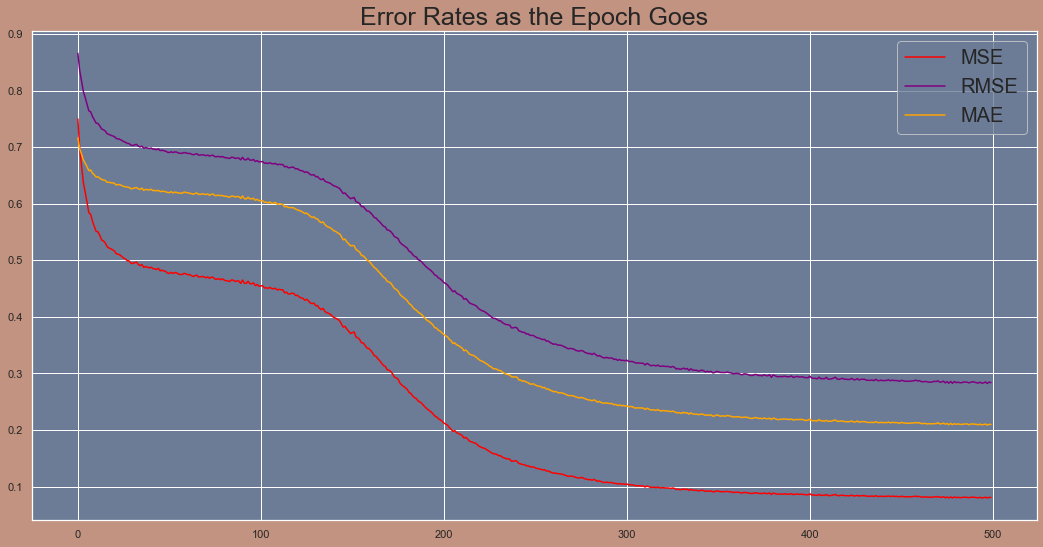

In [10]:
fig, ax = plt.subplots(1,1, figsize=(18,9))
ax.set_title('Error Rates as the Epoch Goes', fontsize=25)
sns.lineplot(err[0][0], label="MSE", color='red')
sns.lineplot(err[0][1], label="RMSE", color='purple')
sns.lineplot(err[0][2], label="MAE", color='orange')


ax.legend(prop={'size':20})
plt.show()


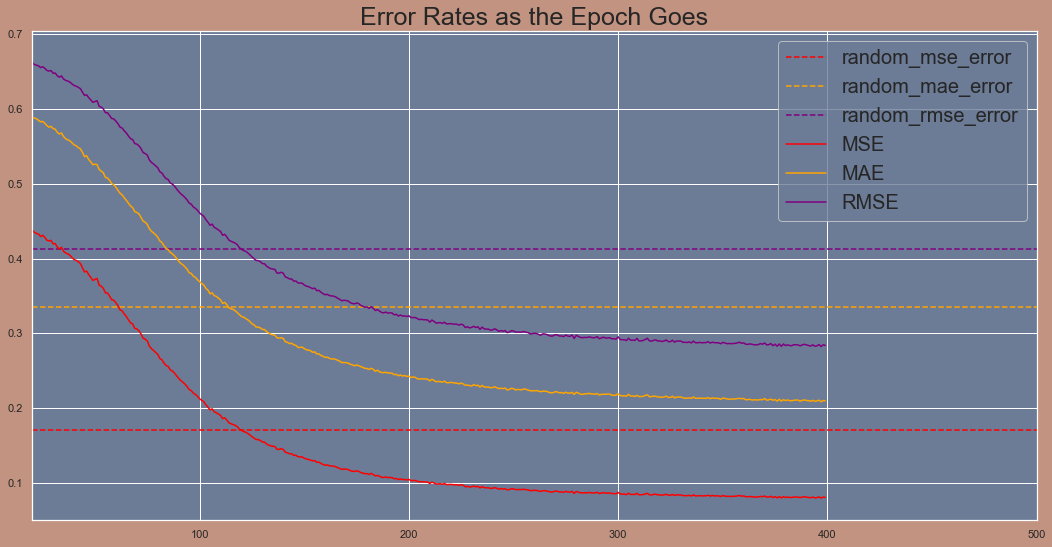

In [26]:
fig, ax = plt.subplots(1,1, figsize=(18,9))
ax.set_title('Error Rates as the Epoch Goes', fontsize=25)
ax.set_xlim(left=20, right=500)

ax.axhline(y=random_mse_error, label="random_mse_error", color="red", linestyle="--")
ax.axhline(y=random_mae_error, label="random_mae_error", color="orange", linestyle="--")
ax.axhline(y=random_rmse_error, label="random_rmse_error", color="purple", linestyle="--")

sns.lineplot(err[0][0][100:], label="MSE", color='red')
sns.lineplot(err[0][2][100:], label="MAE", color='orange')
sns.lineplot(err[0][1][100:], label="RMSE", color='purple')

ax.legend(prop={'size':20})
plt.show()


In [12]:
print("mae at 1th epoch: ",err[0][2][0])
print("mse at 1th epoch: ",err[0][0][0])
print("rmse at 1th epoch: ",err[0][1][0])
print("################")
print("mae at the 100th epoch: ",err[0][2][100])
print("mse at the 100th epoch: ",err[0][0][100])
print("rmse at the 100th epoch: ",err[0][1][100])
print("################")
print("mae at the 200th epoch: ",err[0][2][200])
print("mse at the 200th epoch: ",err[0][0][200])
print("rmse at the 200th epoch: ",err[0][1][200])
print("################")
print("mae at the 300th epoch: ",err[0][2][300])
print("mse at the 300th epoch: ",err[0][0][300])
print("rmse at the 300th epoch: ",err[0][1][300])
print("################")
print("mae at the 400th epoch: ",err[0][2][400])
print("mse at the 400th epoch: ",err[0][0][400])
print("rmse at the 400th epoch: ",err[0][1][400])
print("################")
print("mae at the 500th epoch: ",err[0][2][499])
print("mse at the 500th epoch: ",err[0][0][499])
print("rmse at the 500th epoch: ",err[0][1][499])


mae at 1th epoch:  0.7160730726551546
mse at 1th epoch:  0.749861422469835
rmse at 1th epoch:  0.8659453923139928
################
mae at the 100th epoch:  0.6055435306047859
mse at the 100th epoch:  0.45493437506669465
rmse at the 100th epoch:  0.6744882319705027
################
mae at the 200th epoch:  0.3689563843471026
mse at the 200th epoch:  0.2123432770364258
rmse at the 200th epoch:  0.46080720158915245
################
mae at the 300th epoch:  0.2427844285516016
mse at the 300th epoch:  0.1046394144653281
rmse at the 300th epoch:  0.32348016085276093
################
mae at the 400th epoch:  0.21920869689321862
mse at the 400th epoch:  0.08719658642490448
rmse at the 400th epoch:  0.29529068123614144
################
mae at the 500th epoch:  0.20971011099890013
mse at the 500th epoch:  0.0805351238990983
rmse at the 500th epoch:  0.283787110170808


Conclusion: We can save it like that. Difference of performance metrics between train and test is low.

In [13]:
np.savez("model/item_representation.npz", V)
np.savez("model/user_representation.npz", U)

In [14]:
def model_collaborative_pred(user_id, return_rated_ind=False):
        import pandas as pd
        import numpy as np
        from numpy.linalg import lstsq
        import pickle
        from scipy import sparse

        matrix = sparse.load_npz('model/ui_matrix.npz')

        with open('model/required_data/user_id_encoding.pickle', 'rb') as file:
            user_id_encoding = pickle.load(file)

        user_representation = np.load('model/user_representation.npz')
        predicted_ratings = (U[user_id_encoding[user_id]] * V).sum(1)

        user_nonzero_rated_anm_ids =  matrix[user_id_encoding[user_id]].nonzero()
        if return_rated_ind: # also return the already rated items
            return predicted_ratings, user_nonzero_rated_anm_ids[1]
        else:
            return predicted_ratings

## Comparing

CAN'T EVEN RUN THIS BECAUSE SURPRISE LIBRARY HANDLES DATA INEFFICINETLY,<br>
DATA WON'T FIT INTO RAM

In [ ]:
# from surprise import Dataset
# from surprise import Reader
# from surprise import SVD

# # Define the reader object
# reader = Reader(line_format='user item rating', sep=',', skip_lines=1)

# # Load the data into a Dataset object
# data = Dataset.load_from_file('model_building_variables/ratings_preprocessed.csv', reader=reader)
# algo = SVD()
# algo.fit(trainset)

In [59]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
import pandas as pd

# Define the reader object
reader = Reader(rating_scale=(0,1))


ratings = pd.read_csv('model_building_variables/ratings_preprocessed.csv')
ratings.rename(columns={'user_id':'userId', 'anime_id':'movieId', 'rating':'rating'}, inplace=True)
ratings = ratings.sample(frac=0.001) # take a small piece of the data

# Load the data into a Dataset object
data = Dataset.load_from_df(ratings, reader=reader)
algo = SVD() # will use funk svd

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.25)

# Train the model using the SVD algorithm
algo = SVD()
algo.fit(trainset)

# Make predictions on the test set and calculate the RMSE
predictions = algo.test(testset)

print('= FOR SURPSISE =')
rmse = accuracy.rmse(predictions, verbose=False)
mse = accuracy.mse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)
print(f'RMSE: {rmse:.3f}')
print(f'MSE: {mse:.3f}')
print(f'MAE: {mae:.3f}')

print('= MY ALGO =')
print(f'RMSE: {rmse_error:.3f}')
print(f'MSE: {mse_error:.3f}')
print(f'MAE: {mae_error:.3f}')


FOR SURPSISE:
RMSE: 0.2743
MSE: 0.0752
MAE:  0.1998
MY ALGO:
RMSE: 0.289
MSE: 0.084
MAE: 0.213


Not bad, similar results (a bit worse)  with SVD

## <b>4 - Building Hybrid Filter / Define Recommendation Functions</b>

### 4.a Defining Functions For Content Based Filtering

In [92]:
def get_meta(name: str):
    import pandas as pd
    if 'animes' not in globals().keys():
        animes = pd.read_csv("model/required_data/animes_preprocessed.csv")
    else:
        animes = globals()['animes']

    a = animes[animes['name'].str.lower() == name.lower()]
    if len(a.index)!= 0:
            a = a.iloc[0]
    else:
        try:
            a = animes[animes.name.str.lower().str.contains(name.lower(),
             regex=False)].iloc[0]
        except IndexError:
            print('anime not found')
            return -1
    
    return (a['name'], a['meta_combined'])

def get_synopsis(name: str):
    import pandas as pd
    if 'animes' not in globals().keys():
        animes = pd.read_csv("model/required_data/animes_preprocessed.csv")
    else:
        animes = globals()['animes']

    a = animes[animes['name'].str.lower() == name.lower()]
    if len(a.index)!= 0:
            a = a.iloc[0]
    else:
        try:
            a = animes[animes.name.str.lower().str.contains(name.lower(),
             regex=False)].iloc[0]
        except IndexError:
            print('anime not found')
            return -1
    
    return (a['name'], a['synopsis'])

def get_recommendations_content_based(name: str):
    import numpy as np
    import pandas as pd
    if 'animes' not in globals().keys():
        animes = pd.read_csv("model/required_data/animes_preprocessed.csv")
    else:
        animes = globals()['animes']
    
    if 'cosine_sim' not in globals().keys():
        cosine_sim = np.load("model/anime_similarity_matrix.npy")
    else:
        cosine_sim = globals()['cosine_sim']

    a = animes[animes['name'].str.lower() == name.lower()]
    if len(a.index)!= 0:
            a = a.iloc[0]
    else:
        try:
            a = animes[animes.name.str.lower().str.contains(name.lower(),
             regex=False)].iloc[0]
        except IndexError:
            print('anime not found')
            return -1
    
    print(f"recommendations for {a['name']}:")
    print("\n\n")
    id_encoded = a.anime_id
    similarities_vector = cosine_sim[id_encoded]
    ind = np.argpartition(similarities_vector, -11)[-11:]
    for enc_anm_id in np.flip(ind[np.argsort(similarities_vector[ind])])[1:]:
        err  = round(1-similarities_vector[enc_anm_id],3)
        print(animes.name[animes.anime_id == enc_anm_id].iloc[0],"-->", "with an error of", err)
    
    return 0
    
def get_recommendations_multiple_content_based(names: tuple[str], num_of_animes: int):
    import numpy as np
    import pandas as pd
    if 'animes' not in globals().keys():
        animes = pd.read_csv("model/required_data/animes_preprocessed.csv")
    else:
        animes = globals()['animes']
    
    if 'cosine_sim' not in globals().keys():
        cosine_sim = np.load("model/anime_similarity_matrix.npy")
    else:
        cosine_sim = globals()['cosine_sim']

    input_anime_names = list()
    for name in names:
        a = animes[animes['name'].str.lower() == name.lower()]
        if len(a.index)!= 0:
                a = a.iloc[0]
        else:
            try:
                a = animes[animes.name.str.lower().str.contains(name.lower(),
                regex=False)].iloc[0]
            except IndexError:
                print('anime not found')
                return -1
            
        input_anime_names.append(a)
    
    name_str = "["+'\n'.join([a['name'] for a in input_anime_names]) + "]\n"
    print("recommendations for:\n", name_str)
    print("\n\n\n")

    id_encoded = [a.anime_id for a in input_anime_names]
    similarities_vector = cosine_sim[id_encoded].mean(axis=0)

    mask = np.ones(len(similarities_vector), bool)
    mask[id_encoded] = 0
    ind = np.argsort(similarities_vector)
    ind = ind[mask]

    for enc_anm_id in np.flip(ind[np.argsort(similarities_vector[ind])])[:num_of_animes]:
        err  = round(1-similarities_vector[enc_anm_id],3)
        print(animes.name[animes.anime_id == enc_anm_id].iloc[0],"-->", "with an error of", err)
    
    return 0
    

### 4.b Defining Functions For Collaborative Based Filtering

In [96]:
def get_recommendations_collaborative_based(user_id, num_of_animes, return_animes=False, print_rating=False):
    import numpy as np
    import pandas as pd
    
    try: 
        predictions, rated_index = model_collaborative_pred(user_id=user_id, return_rated_ind=True)
    except Exception as e:
        print('user_id not found.')
        print(e)
        return -1

    mask = np.ones(len(predictions), bool)
    mask[rated_index] = 0

    ind = (-predictions).argsort()
    ind = ind[mask]
    ind = ind[:num_of_animes]


    animes = pd.read_csv('model/required_data/animes_preprocessed.csv')

    animes = animes[animes.anime_id.isin(ind)]
    print("Recommending anime for user: ", user_id, end="\n\n")
    for i in ind:
        print(f"{animes.loc[i, 'name']}")
        if print_rating:
            print(f"with expected rating of: {predictions[i]*10}")
    
    if return_animes:
        return animes

def get_fav_animes(user_id, num_of_anime, return_animes=False, print_rating=False):
    import numpy as np
    import pandas as pd
    import pickle
    from scipy import sparse
    
    matrix = sparse.load_npz('model/ui_matrix.npz')
    anime_df = pd.read_csv('model/required_data/animes_preprocessed.csv')

    
    with open('model/required_data/user_id_encoding.pickle', 'rb') as file:
        user_id_encoding = pickle.load(file)
    
    try:
        user_rating_vector = matrix[user_id_encoding[user_id]].toarray().flatten()
    except KeyError:
        print("User not found")
        return -1

    ind = (-user_rating_vector).argsort()[:num_of_anime]

    animes = pd.read_csv('model/required_data/animes_preprocessed.csv')

    animes = animes[animes.anime_id.isin(ind)]
    for i in ind:
        print(f"Favorite anime: {animes.loc[i, 'name']}")
        if print_rating:
            print(f"with rating of: {user_rating_vector[i]*10}")
    
    if return_animes:
        return animes


### 4.c Defining Hybrid Filtering

In [94]:
def hybrid(user_id, animes: tuple, num_of_animes=10):
    """Switch style recommendation system"""

    import pickle
    with open('model/required_data/user_id_encoding.pickle', 'rb') as file:
        user_id_encoding = pickle.load(file)

    cond = user_id in user_id_encoding.keys()
    if cond:
        get_recommendations_collaborative_based(user_id=user_id, num_of_animes=num_of_animes)
    elif len(animes) == 0:
        print("User ID is not in the database.")
        print("Model hasn't got knowledge about the user.")
        print("Please specify contents.")
        return -1
    else:
        get_recommendations_multiple_content_based(animes, num_of_animes=num_of_animes)


## <b>5 - Using The Main Program</b>

In [18]:
get_recommendations_content_based("Naruto")


recommendations for Naruto:



Naruto: Shippuuden --> with an error of 0.228
Boruto: Naruto Next Generations --> with an error of 0.362
Naruto: Shippuuden Movie 6 - Road to Ninja --> with an error of 0.448
Boruto: Naruto the Movie --> with an error of 0.481
Naruto: Shippuuden Movie 4 - The Lost Tower --> with an error of 0.482
Naruto: Shippuuden Movie 5 - Blood Prison --> with an error of 0.506
Saint Seiya: The Lost Canvas - Meiou Shinwa 2 --> with an error of 0.522
Naruto: Takigakure no Shitou - Ore ga Eiyuu Dattebayo! --> with an error of 0.524
Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!! --> with an error of 0.53
Duel Masters VS --> with an error of 0.53


0

In [19]:
get_recommendations_content_based("Dragon Ball Z")

recommendations for Dragon Ball Z:



Dragon Ball Z: Zenbu Misemasu Toshi Wasure Dragon Ball Z! --> with an error of 0.325
Dragon Ball Kai --> with an error of 0.419
Dragon Ball Z Movie 14: Kami to Kami --> with an error of 0.465
Dragon Ball GT --> with an error of 0.49
Dragon Ball --> with an error of 0.506
One Piece Film: Strong World --> with an error of 0.531
One Piece --> with an error of 0.552
Kizuna Ichigeki --> with an error of 0.559
Dragon Ball Kai: Mirai ni Heiwa wo! Goku no Tamashii yo Eien ni --> with an error of 0.562
Saint Seiya: The Lost Canvas - Meiou Shinwa 2 --> with an error of 0.572


0

In [20]:
get_recommendations_content_based("Kizuna Ichigeki")


recommendations for Kizuna Ichigeki:



Dragon Ball Z: Zenbu Misemasu Toshi Wasure Dragon Ball Z! --> with an error of 0.524
Dragon Ball Z --> with an error of 0.559
Manga --> with an error of 0.705
Kemeko no Love --> with an error of 0.705
Dekobou Shingachou: Meian no Shippai --> with an error of 0.705
Pop --> with an error of 0.705
Kitte no Gensou --> with an error of 0.705
Ooatari Sora no Entaku --> with an error of 0.705
Imokawa Mukuzo: Chuugaeri no Maki --> with an error of 0.705
Tengu Taiji --> with an error of 0.705


0

In [21]:
get_meta("Kizuna Ichigeki")

('Kizuna Ichigeki',
 'ascension imagine comedy martialarts comedy martialarts movie original kizuna kizuna kizuna tournament tournament tournament todoroki todoroki todoroki martial martial martial arts arts reporter reporter world world grandfather grandfather winning winning winnings')

In [30]:
get_recommendations_collaborative_based(11, 10)

Recommending anime: Tezuka Osamu ga Kieta?! 20 Seiki Saigo no Kaijiken
Recommending anime: Kochira Katsushikaku Kameari Kouenmae Hashutsujo: The Final - Ryoutsu Kakichi Saigo no Hi
Recommending anime: gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?
Recommending anime: Daisetsusan no Yuusha Kibaou
Recommending anime: Tantei Opera Milky Holmes: Psycho no Aisatsu
Recommending anime: Yousei Hime Ren
Recommending anime: Chao Zhi Neng Zu Qiu
Recommending anime: Otousan wa Ai no Hito
Recommending anime: Ma Shen
Recommending anime: Sinbad: Mahiru no Yoru to Fushigi no Mon


In [46]:
get_fav_animes(11, 10)

Favorite anime: Servant x Service
Favorite anime: Working'!!
Favorite anime: Working!!
Favorite anime: Ao no Exorcist
Favorite anime: Kyoukai no Kanata
Favorite anime: Log Horizon
Favorite anime: Kami nomi zo Shiru Sekai: Megami-hen
Favorite anime: Date A Live
Favorite anime: Shijou Saikyou no Deshi Kenichi
Favorite anime: Gekkan Shoujo Nozaki-kun


In [48]:
get_recommendations_content_based("Ao no Exorcist")

recommendations for Ao no Exorcist:



Ao no Exorcist: Kyoto Fujouou-hen --> with an error of 0.461
Bakegyamon --> with an error of 0.597
Kuroshitsuji --> with an error of 0.61
Ao no Exorcist: Kuro no Iede --> with an error of 0.623
Enen no Shouboutai: Ni no Shou --> with an error of 0.625
Gensoumaden Saiyuuki --> with an error of 0.626
Luger Code 1951 --> with an error of 0.629
Shounen Sunday CM Gekijou: InuYasha-hen --> with an error of 0.632
Shingeki no Bahamut: Virgin Soul --> with an error of 0.644
Amatsuki --> with an error of 0.646


0

In [90]:
hybrid(11213312, ('Dragon Ball Kai', 'One Piece', 'Duel Masters VS'), num_of_animes=10)

recommendations for:
 [Dragon Ball Kai
One Piece
Duel Masters VS]





Duel Masters VS --> with an error of 0.372
Duel Masters! --> with an error of 0.372
One Piece --> with an error of 0.393
Duel Masters Cross --> with an error of 0.405
Dragon Ball Kai --> with an error of 0.407
One Piece Film: Strong World --> with an error of 0.411
Duel Masters Cross Shock --> with an error of 0.42
Moeru! Oniisan --> with an error of 0.487
One Piece Film: Z --> with an error of 0.491
Wellber no Monogatari: Kanashimi no Senshi Galahad no Banka --> with an error of 0.498


In [97]:
hybrid(1, ('Dragon Ball Kai', 'One Piece', 'Duel Masters VS'), num_of_animes=10)

Recommending anime for user:  1

Bem Movie: Become Human
Barbapapa
Shanhe Jian Xin
Araiguma Rascal
Aoki Ryuusei SPT Layzner OVA
Balloon (Music)
Soosee no Aquarion: Dai 27-wa Parallel-ban
Kirakira☆Precure A La Mode Movie: Paritto! Omoide no Mille-Feuille!
Inakappe Taishou
A-jang.com


In [98]:
hybrid(11213312, (), num_of_animes=10)

User ID is not in the database.
Model hasn't got knowledge about the user.
Please specify contents.


-1